Disentangled representations with $\beta$-VAE and forced learning of some traits for Radio Galaxies

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood

In [25]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.vae_models import VAE

In [3]:
%%time
data_path = '../data/'
aug=15
lrg_data_set   = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                                                               file_dir=data_path + 'lrg')

unlrg_data_set = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table4.txt',
                                                               file_dir=data_path + 'unlrg')

../data/lrg:	1442/1442
../data/unlrg:	14245/14245
CPU times: user 5min 52s, sys: 6min 17s, total: 12min 9s
Wall time: 4min 4s


In [23]:
x, y = unlrg_data_set.get_data()
y = np.array(y)

x = x[y != 1]
y = y[y != 1]

unlrg_images, unlrg_lables = x, y
##############################################
x, y = lrg_data_set.get_data()
y = np.array(y)

x = x[y != 1]
y = y[y != 1]
lrg_images, lrg_lables = x, y

In [4]:
# batch_size = 128
# data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=batch_size, shuffle=False)
# data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=batch_size, shuffle=True)

# sample = iter(data_loader_lrg).next()

In [26]:
# data_path = '../data/'

# lrg_images   = np.load(data_path+'proc_aligned2/lrg_norm_proc.npy', allow_pickle=True)
# unlrg_images = np.load(data_path+'proc_aligned2/unlrg_norm_proc.npy', allow_pickle=True)

# aug=15

my_lrg_dataset  = BasicDataset(lrg_images, lrg_data_set.labels, n_aug=2) #
my_unlrg_dataset  = BasicDataset(unlrg_images, unlrg_data_set.labels, n_aug=10)

batch_size = 128
data_loader_lrg   = data.DataLoader(my_lrg_dataset,   batch_size=batch_size, shuffle=False)
data_loader_unlrg = data.DataLoader(my_unlrg_dataset, batch_size=batch_size, shuffle=True)

sample = iter(data_loader_lrg).next()

In [27]:
#Simple Variational Auto Encoder
class VAE(nn.Module):
    def __init__(self, lt_dim=4, use_STN=True, batchNorm=True, dropout=True, activation_fnc = nn.ReLU):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
        encoder_layers = []
        decoder_layers = []
        ####################### STN STUFF ###################
        self.use_STN = use_STN
        final_size = 2*3
        final_bias = torch.cuda.FloatTensor([1, 0, 0, 0, 1, 0])

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.AdaptiveMaxPool2d(output_size=(3, 3)),
            nn.ReLU(True)
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, final_size)
        )
        self.activation_fnc = activation_fnc
        # initialize to identity for rotation or affine
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(final_bias)
        #####################################################
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            if batchNorm: 
                encoder_layers.append(nn.BatchNorm2d(self.k[i+1]))
            encoder_layers.append(self.activation_fnc())
            if dropout:
                encoder_layers.append(nn.Dropout2d())

        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            if i == 1:
                continue
            if batchNorm: 
                decoder_layers.append(nn.BatchNorm2d(self.k[i - 1]))
            decoder_layers.append(self.activation_fnc())
            if dropout:
                decoder_layers.append(nn.Dropout2d())


        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    
    def get_stn_params(self, x):
        x = self.localization(x)
        x = x.view(-1, 10 * 3 * 3)
        stn_output = self.fc_loc(x)

        affine_params = stn_output.view(-1, 2, 3)
        return affine_params

    def affine(self, x, affine_params, padding_mode='zeros'):
        grid = F.affine_grid(affine_params, x.size()).cuda()
        x = F.grid_sample(x, grid, padding_mode=padding_mode)
        return x
    
    def affine_inv(self, x, affine_params, padding_mode='zeros'):
        inv_affine_params = torch.cuda.FloatTensor(affine_params.size()).fill_(0)
        A_inv =  torch.inverse(affine_params[:, :, :2].squeeze())
        b = affine_params[:, : , 2:]
        b_inv = torch.matmul(A_inv, b)
        b_inv = b_inv.squeeze()
        inv_affine_params[:, :2, :2] = A_inv
        inv_affine_params[:, :, 2]   = -1 * b_inv
        grid = F.affine_grid(inv_affine_params, x.size()).cuda()
        x = F.grid_sample(x, grid, padding_mode=padding_mode)
        return x

    def encode(self, x):
        if self.use_STN:
            self.affine_params = self.get_stn_params(x)
            x = self.affine(x, self.affine_params)

        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        if self.training :
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        else :
            return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        x = torch.sigmoid(self.decoder(x))
        if self.use_STN:
            x = self.affine_inv(x, self.affine_params)
        return x

    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [28]:
class B_VAE_Loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
        self.recon_ls = nn.BCELoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [37]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
#         extended = target > 1
#         extended = Variable(extended.float().to(device), requires_grad=False)
#         pred_ext = torch.sigmoid(output[1][:,0])
#         ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss #+ 10 * (ext_loss)#+ fr_loss)# + reg_loss)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:3d} ({:3.0f}%)  Loss: {:4.4f}  R_Loss: {:4.4f}  Capacity: {:4.2f}'
        s = s.format(epoch,
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [30]:
def test_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.eval()
    loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)

            # BCE Loss
            c, r_loss , g_loss = beta_vae_loss(output, data)
            loss = r_loss
    return loss

In [31]:
device = 'cuda'
lt_dim = 10
lr= 0.0001
lambda_lr = lambda epoch : np.power(0.75, epoch / 5)
epochs = 20
gam = 10
cap = 10
beta_vae_loss = B_VAE_Loss(gamma=gam, max_capacity=cap, epochs=epochs)

In [32]:
def do_training(vae, optimizer, scheduler):
    for epoch in range(1, epochs+1):
        #LRG, forced params
        start = time.time()
        s = train_step(vae, 'cuda', data_loader_unlrg, optimizer, epoch)
        loss = test_step(vae, 'cuda', data_loader_lrg, optimizer, epoch)
        t = time.time() - start
        sys.stdout.write('{}   Test Loss : {:4.4f}   Time : {:.2f}s   LR: {}\n'.format(s, loss, t, scheduler.get_lr()[0]))
        beta_vae_loss.update()
#         scheduler.step()

In [33]:
# %%time
# vae = VAE(lt_dim=lt_dim, use_STN=True, activation_fnc=nn.ELU).to(device)
# optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

# scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
# do_training(vae, optimizer, scheduler)
# torch.save(vae, 'b_vae_soft_stn_elu')

In [34]:
# a = 1
# vae.eval()
# s, l = sample[0][a:a+1], sample[1][a:a+1]
# with torch.no_grad():
#     e = vae.encode(s.to(device))[0]
#     d = vae.decode(e)
# f, ax = plt.subplots(1, 3, figsize=(10, 5))
# ax[0].imshow(s[0][0])
# ax[1].imshow(d.cpu()[0][0])
# ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
# ax[0].axis('off')
# ax[1].axis('off')
# ax[2].axis('off')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=True, dropout=False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=0.0005, weight_decay=1E-5)
beta_vae_loss = B_VAE_Loss(gamma=gam, max_capacity=cap, epochs=epochs)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop')

Train Epoch:   1 (100%)  Loss: 401.5721  R_Loss: 387.6564  Capacity: 0.00   Test Loss : 504.1428   Time : 48.30s   LR: 0.0005
Train Epoch:   2 (100%)  Loss: 211.5902  R_Loss: 208.8893  Capacity: 0.10   Test Loss : 460.7953   Time : 48.33s   LR: 0.0005
Train Epoch:   3 (100%)  Loss: 162.8667  R_Loss: 156.2253  Capacity: 0.20   Test Loss : 276.6544   Time : 48.53s   LR: 0.0005
Train Epoch:   4 (100%)  Loss: 136.5558  R_Loss: 127.4948  Capacity: 0.30   Test Loss : 244.6234   Time : 48.67s   LR: 0.0005
Train Epoch:   5 (100%)  Loss: 122.9975  R_Loss: 113.7163  Capacity: 0.40   Test Loss : 254.7898   Time : 48.56s   LR: 0.0005
Train Epoch:   6 (100%)  Loss: 136.8647  R_Loss: 126.0702  Capacity: 0.50   Test Loss : 237.4881   Time : 51.63s   LR: 0.0005
Train Epoch:   7 (100%)  Loss: 119.9600  R_Loss: 112.0980  Capacity: 0.60   Test Loss : 244.0630   Time : 50.34s   LR: 0.0005
Train Epoch:   8 (100%)  Loss: 120.9223  R_Loss: 113.1780  Capacity: 0.70   Test Loss : 230.8424   Time : 50.11s   LR:

(-0.5, 63.5, 63.5, -0.5)

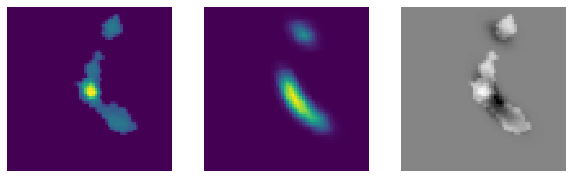

In [36]:
a = 1
vae.eval()
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

torch.Size([1, 1, 64, 64])


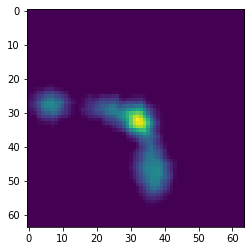

In [24]:
rs = np.rot90(s[0][0].numpy())
plt.imshow(rs)
rs = torch.tensor([[rs]])
print(rs.shape)

In [25]:
with torch.no_grad():
    vae = torch.load('b_vae_soft_stn_elu_nodrop')
    affine_params = vae.get_stn_params(rs.to(device))
    affine_output = vae.affine(rs.to(device), affine_params)

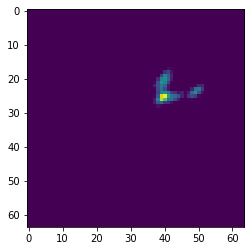

In [26]:
plt.imshow(affine_output[0][0].cpu())

In [ ]:
a = 1
vae.eval()
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=True, dropout= False, batchNorm=False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)
beta_vae_loss = B_VAE_Loss(gamma=gam, max_capacity=cap, epochs=epochs)
scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop_nonorm')

In [ ]:
a = 1
vae.eval()
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_elu')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=False, dropout= False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=False, dropout= False, batchNorm=False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop_nonorm')